In [1]:
import sys
import os

PROJECT = os.path.abspath("..")
if PROJECT not in sys.path:
    sys.path.append(PROJECT)
import numpy as np
import matplotlib.pyplot as plt
from src.utils import plot_predictions, inverse_transform
from keras.models import load_model,Model
from src.models.custom_layers import Attention
from src.data_loader import load_processed_data
import seaborn as sns
MODELS_DIR = os.path.join(PROJECT, "results/models")
PLOTS_DIR = os.path.join(PROJECT, "results/plots")
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

Load Processed Data

In [2]:
processed_folder = os.path.join(PROJECT, "data/processed")
X_train, y_train, X_test, y_test, scaler = load_processed_data(processed_folder)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_test shape: (27980, 48, 1)
y_test shape: (27980, 24, 1)


Load Models

In [3]:
baseline_model = load_model(os.path.join(MODELS_DIR, "lstm_baseline.keras"),compile=False)

attention_model = load_model(os.path.join(MODELS_DIR, "lstm_attention.keras"),
                    custom_objects={"Attention": Attention},
                    compile=False)

print("Models loaded")



Models loaded


Predict

In [4]:
#Baseline predictions
y_pred_baseline = baseline_model.predict(X_test)

# Attention predictions
y_pred_attention = attention_model.predict(X_test)

# Inverse scale
y_test_inv = inverse_transform(scaler, y_test)
y_pred_baseline_inv = inverse_transform(scaler, y_pred_baseline)
y_pred_attention_inv = inverse_transform(scaler, y_pred_attention)

875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step


Evaluate

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    return rmse, mae

rmse_base, mae_base = evaluate(y_test_inv, y_pred_baseline_inv)
rmse_attn, mae_attn = evaluate(y_test_inv, y_pred_attention_inv)

print(f"Baseline -> RMSE: {rmse_base:.2f}, MAE: {mae_base:.2f}")
print(f"Attention -> RMSE: {rmse_attn:.2f}, MAE: {mae_attn:.2f}")

Baseline -> RMSE: 3.38, MAE: 1.74
Attention -> RMSE: 3.44, MAE: 1.72


In [6]:
def plot_predictions(y_true, y_pred, steps_to_plot=200, title="Predictions vs Actual"):
    plt.figure(figsize=(12,6))
    plt.plot(y_true[:steps_to_plot], label="Actual", marker='o')
    plt.plot(y_pred[:steps_to_plot], label="Predicted", marker='x')
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()


Baseline saved


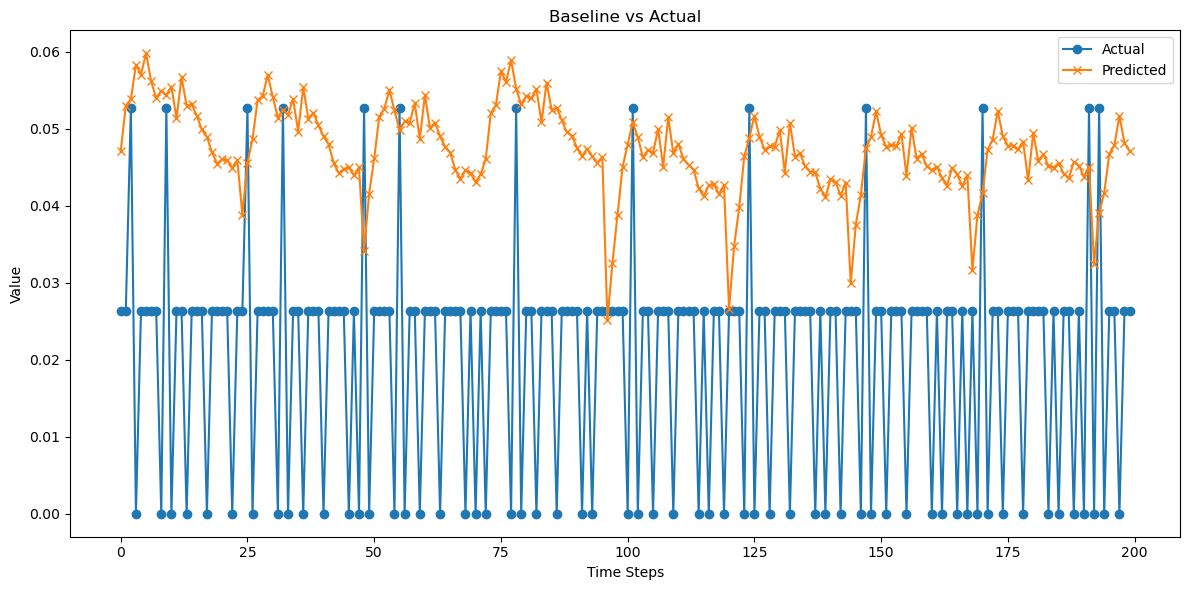

In [7]:
# Baseline
plot_predictions(y_test.flatten(), y_pred_baseline.flatten(), title="Baseline vs Actual")
plt.savefig(os.path.join(PLOTS_DIR, "baseline_vs_actual.png"),dpi=300, bbox_inches="tight")
print("Baseline saved")
plt.show()

Attention  saved


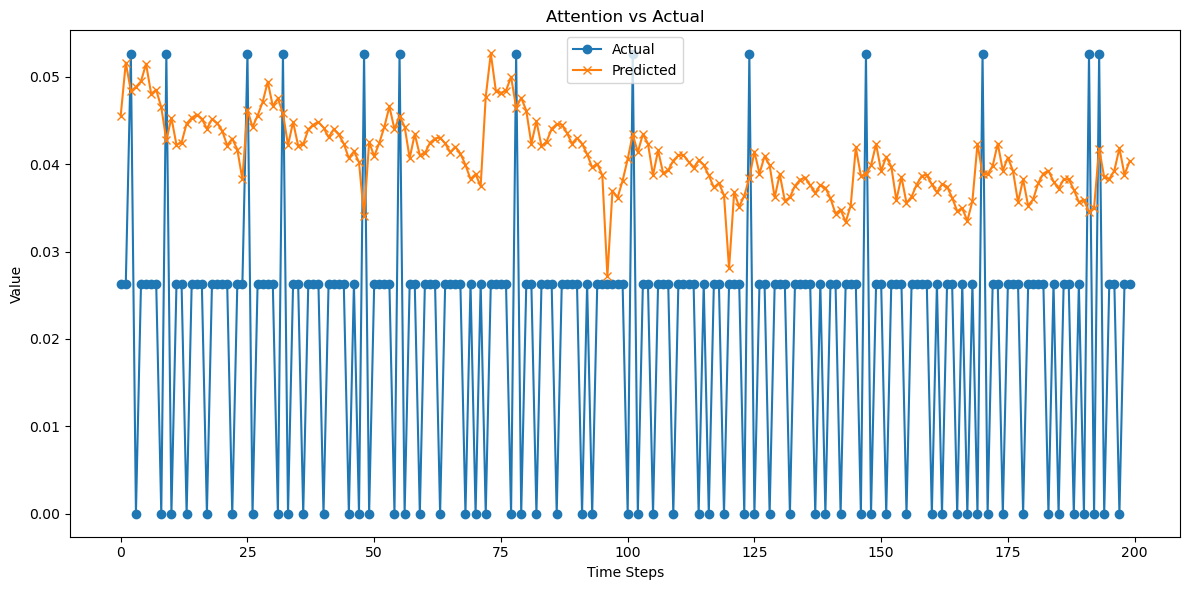

In [8]:
#Attention
plot_predictions(y_test.flatten(),y_pred_attention.flatten(),title="Attention vs Actual")
plt.savefig(os.path.join(PLOTS_DIR, "attention_vs_actual.png"),dpi=300, bbox_inches="tight")
print("Attention  saved")
plt.show()

Attention Weights Heatmap

875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


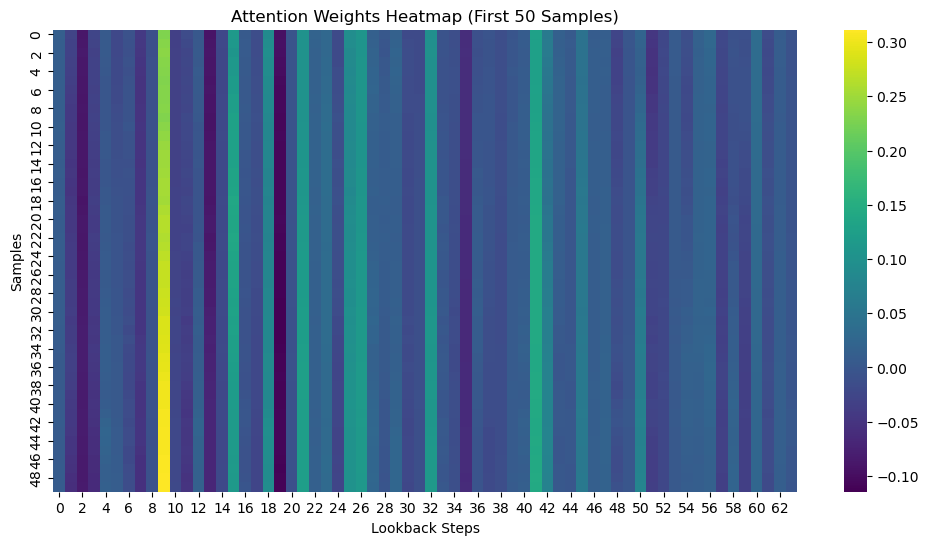

In [9]:

attention_layer_model = Model(inputs=attention_model.input,
                            outputs=attention_model.get_layer("attention").output) 

attention_weights = attention_layer_model.predict(X_test) 

plt.figure(figsize=(12,6))
sns.heatmap(attention_weights[:50], cmap="viridis", cbar=True)
plt.xlabel("Lookback Steps")
plt.ylabel("Samples")
plt.title("Attention Weights Heatmap (First 50 Samples)")
plt.savefig(os.path.join(PLOTS_DIR, "attention_heatmap.png"))
plt.show()